# 🏨 Hospitality Revenue Analytics
**C&A Summer Project @ IIT Guwahati (2025)**  
This notebook analyzes hotel booking and revenue data across multiple room categories to detect revenue leakage, underutilization, and propose data-driven consulting recommendations.
 

In [1]:
#IMPORT LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#LOAD DATA
fact_bookings = pd.read_csv('fact_bookings.csv')
dim_date = pd.read_csv('dim_date.csv')
dim_hotels = pd.read_csv('dim_hotels.csv')
dim_rooms = pd.read_csv('dim_rooms.csv')
fact_agg = pd.read_csv('fact_aggregated_bookings.csv')

In [3]:
#CONVERT DATE COLUMNS
fact_bookings['booking_date'] = pd.to_datetime(fact_bookings['booking_date'])
fact_bookings['check_in_date'] = pd.to_datetime(fact_bookings['check_in_date'])
fact_bookings['checkout_date'] = pd.to_datetime(fact_bookings['checkout_date'])
fact_agg['check_in_date'] = pd.to_datetime(fact_agg['check_in_date'])
dim_date['date'] = pd.to_datetime(dim_date['date'])

C:\Users\somit\AppData\Local\Temp\ipykernel_28160\1909947491.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  fact_agg['check_in_date'] = pd.to_datetime(fact_agg['check_in_date'])
C:\Users\somit\AppData\Local\Temp\ipykernel_28160\1909947491.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dim_date['date'] = pd.to_datetime(dim_date['date'])


## Merge Data 

In [4]:
bookings = fact_bookings.merge(dim_hotels, on='property_id', how='left')
bookings = bookings.merge(dim_date, left_on='check_in_date', right_on='date', how='left')
agg = fact_agg.merge(dim_hotels, on='property_id', how='left')
agg = agg.merge(dim_date, left_on='check_in_date', right_on='date', how='left')

## Occupancy Rate Analysis

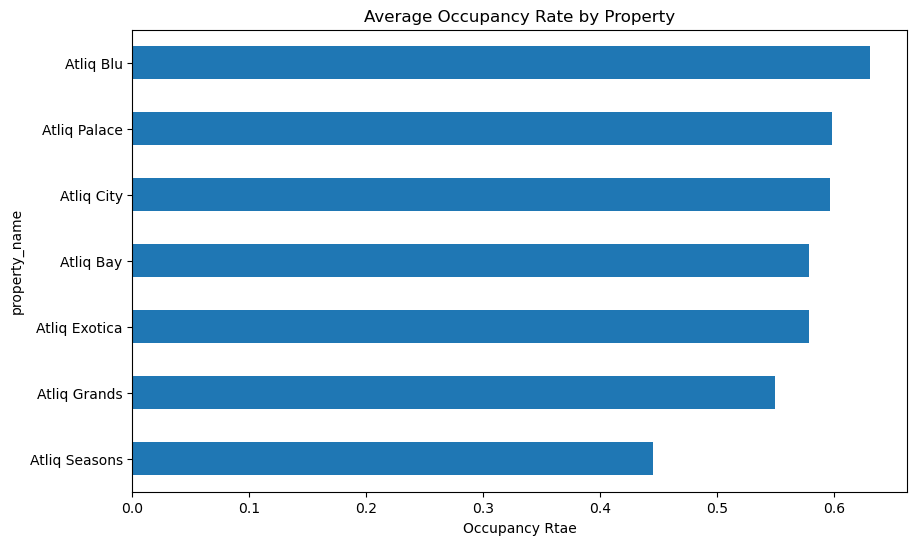

In [5]:
agg['occupancy_rate'] = agg['successful_bookings']/agg['capacity']
occupancy_summary = agg.groupby('property_name')['occupancy_rate'].mean().sort_values()
occupancy_summary.plot(kind = 'barh' ,figsize=(10,6), title = 'Average Occupancy Rate by Property')
plt.xlabel('Occupancy Rtae')
plt.show()                       

## Leakage Revenue

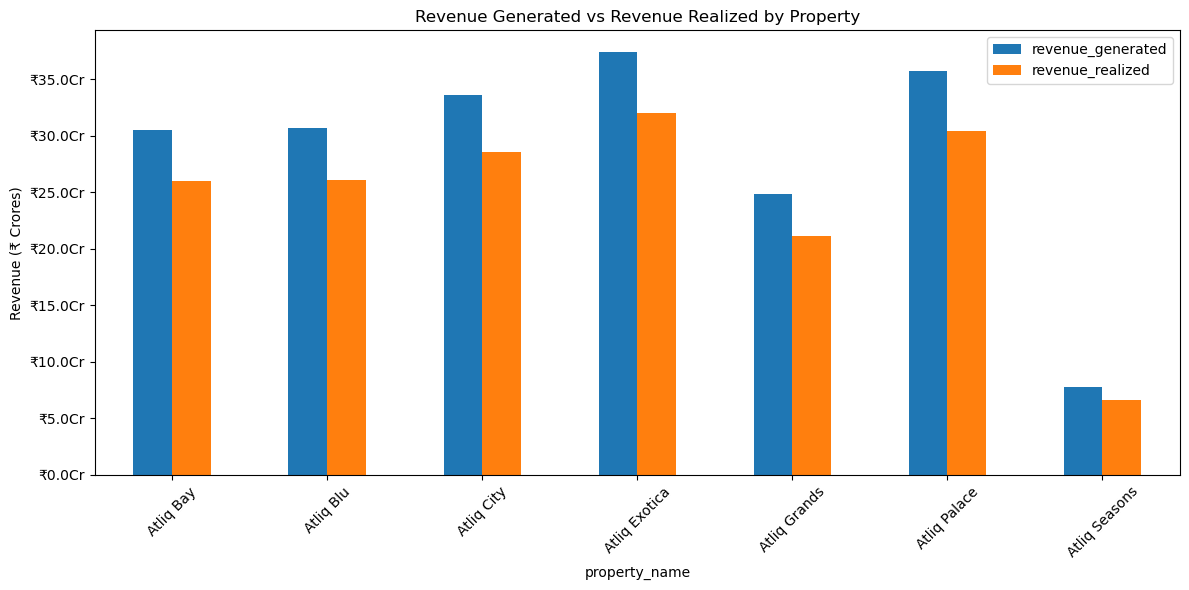

In [6]:
import matplotlib.ticker as mtick
revenue = bookings.groupby('property_name')[['revenue_generated', 'revenue_realized']].sum()
revenue = revenue/1e7

ax = revenue.plot(kind='bar', figsize=(12,6), title='Revenue Generated vs Revenue Realized by Property')
plt.ylabel('Revenue (₹ Crores)')
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('₹{x:,.1f}Cr'))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Cancellation Analysis

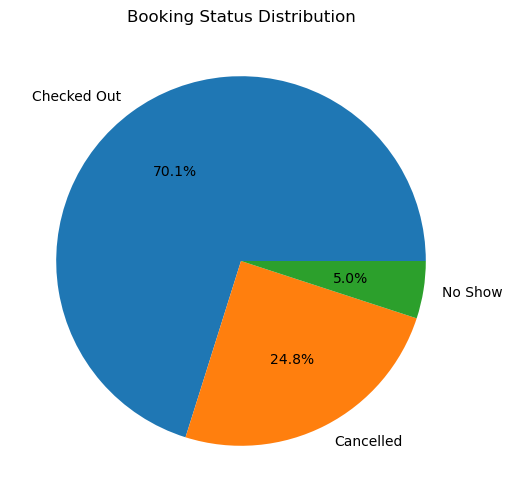

In [7]:
cancel_rate = bookings['booking_status'].value_counts(normalize=True) * 100
cancel_rate.plot(kind='pie', autopct='%1.1f%%', title='Booking Status Distribution', figsize=(6,6))
plt.ylabel('')
plt.show()

## Weekday vs Weekend Analysis

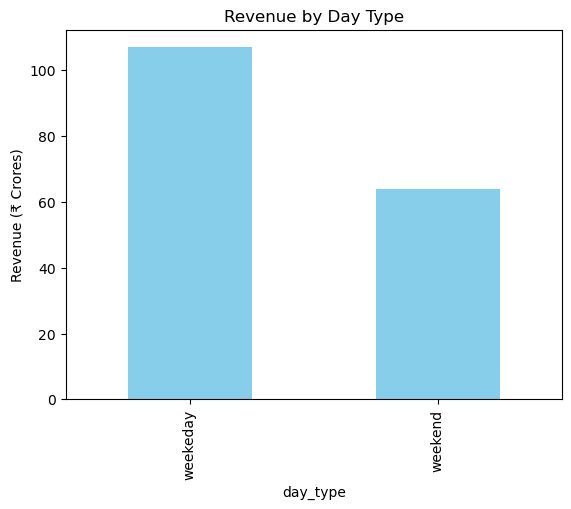

In [8]:
day_type_rev = bookings.groupby('day_type')['revenue_realized'].sum()
day_type_rev=day_type_rev/1e7
day_type_rev.plot(kind='bar', color='skyblue', title='Revenue by Day Type')
plt.ylabel('Revenue (₹ Crores)')
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('₹{x:,.1f}Cr'))
plt.show()

In [9]:
agg = fact_agg.merge(dim_date, left_on='check_in_date', right_on='date', how='left')

agg['occupancy_rate'] = agg['successful_bookings'] / agg['capacity']

low_days = agg.groupby(agg['date'].dt.day_name())['occupancy_rate'].mean().sort_values()
print(low_days)

date
Tuesday      0.516259
Wednesday    0.516856
Thursday     0.518992
Friday       0.519085
Monday       0.519154
Sunday       0.737035
Saturday     0.742365
Name: occupancy_rate, dtype: float64


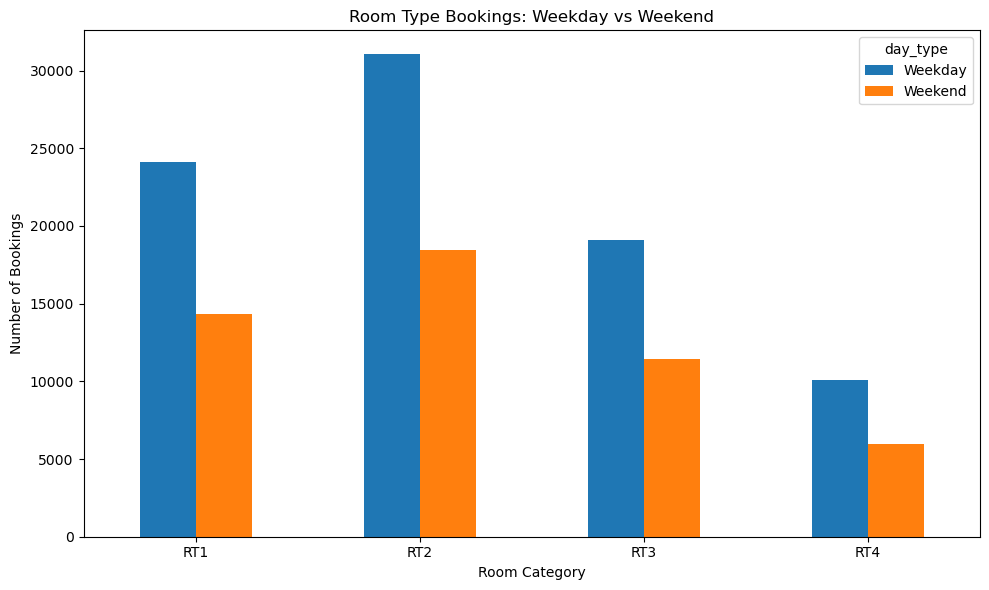

In [10]:

bookings['check_in_day'] = bookings['check_in_date'].dt.day_name()
bookings['day_type'] = bookings['check_in_day'].apply(lambda x: 'Weekend' if x in ['Saturday', 'Sunday'] else 'Weekday')

day_type_bookings = bookings['day_type'].value_counts()
room_type_trends = bookings['room_category'].value_counts()

pivot = bookings.pivot_table(index='room_category', columns='day_type', values='booking_id', aggfunc='count')

ax = pivot.plot(kind='bar', figsize=(10,6), title='Room Type Bookings: Weekday vs Weekend')
plt.ylabel('Number of Bookings')
plt.xlabel('Room Category')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()




## Seasonal Occupancy vs Revenue

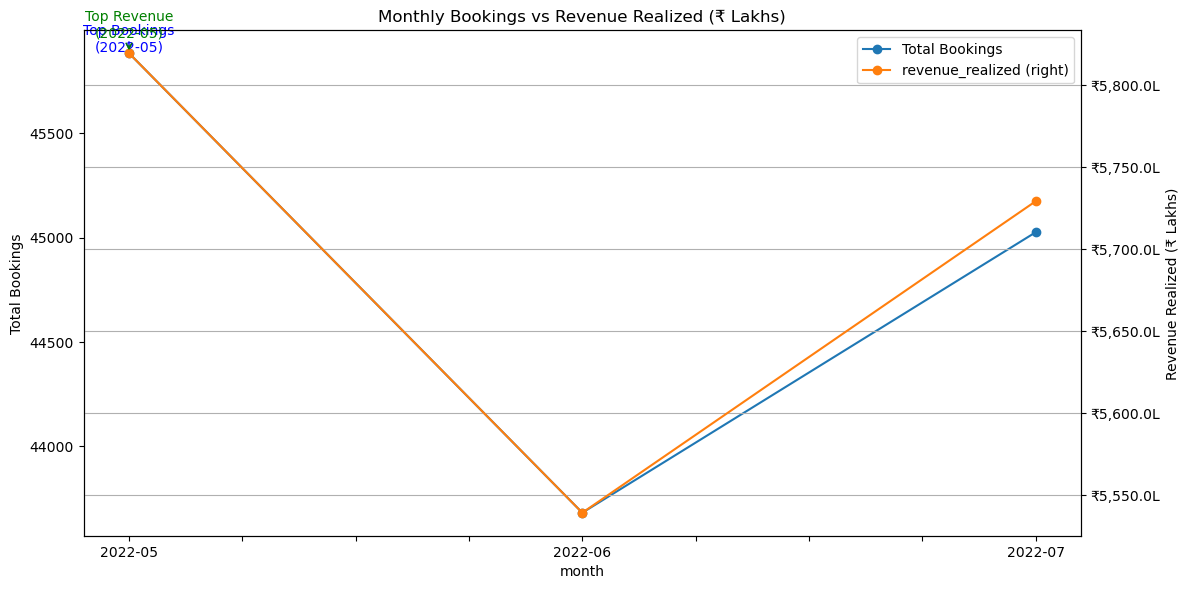

In [11]:

bookings['month'] = bookings['check_in_date'].dt.to_period('M').astype(str)
monthly_stats = bookings.groupby('month').agg({
    'booking_id': 'count',
    'revenue_realized': 'sum'
}).rename(columns={'booking_id': 'Total Bookings'})
monthly_stats['revenue_realized'] = monthly_stats['revenue_realized'] / 1e5
ax = monthly_stats.plot(
    secondary_y='revenue_realized',
    figsize=(12, 6),
    title='Monthly Bookings vs Revenue Realized (₹ Lakhs)',
    marker='o'
)
ax.set_ylabel('Total Bookings')
ax.right_ax.set_ylabel('Revenue Realized (₹ Lakhs)')
ax.right_ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('₹{x:,.1f}L'))
top_rev_month = monthly_stats['revenue_realized'].idxmax()
top_book_month = monthly_stats['Total Bookings'].idxmax()
x_labels = list(monthly_stats.index)
rev_x = x_labels.index(top_rev_month)
book_x = x_labels.index(top_book_month)
ax.right_ax.annotate(
    f"Top Revenue\n({top_rev_month})",
    xy=(rev_x, monthly_stats.loc[top_rev_month, 'revenue_realized']),
    xytext=(rev_x, monthly_stats['revenue_realized'].max() + 10),
    arrowprops=dict(arrowstyle='->', color='green'),
    color='green',
    ha='center'
)

ax.annotate(
    f"Top Bookings\n({top_book_month})",
    xy=(book_x, monthly_stats.loc[top_book_month, 'Total Bookings']),
    xytext=(book_x, monthly_stats['Total Bookings'].max() + 10),
    arrowprops=dict(arrowstyle='->', color='blue'),
    color='blue',
    ha='center'
)
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()



## Ancillary Service Usage Analysis(Spa,Meals,Transport)

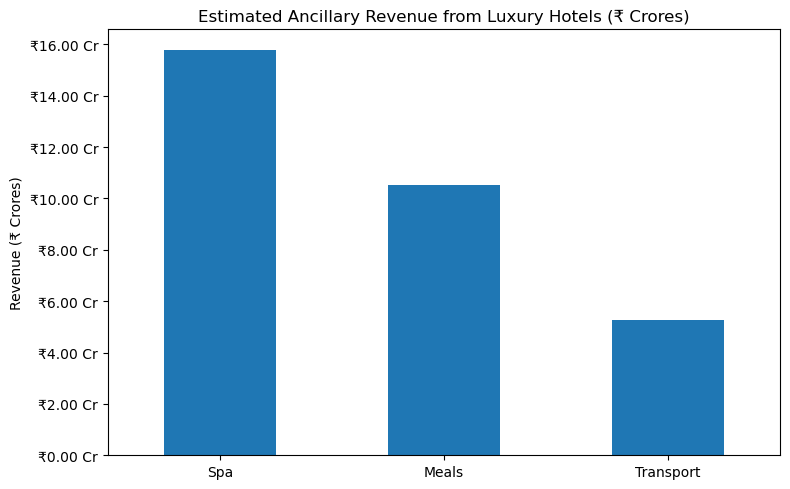

In [12]:
luxury_bookings = bookings[bookings['category'] == 'Luxury'].copy()
luxury_bookings['spa_revenue'] = luxury_bookings['revenue_realized'] * 0.15
luxury_bookings['meals_revenue'] = luxury_bookings['revenue_realized'] * 0.10
luxury_bookings['transport_revenue'] = luxury_bookings['revenue_realized'] * 0.05
ancillary_summary = pd.DataFrame({
    'Spa': [luxury_bookings['spa_revenue'].sum()],
    'Meals': [luxury_bookings['meals_revenue'].sum()],
    'Transport': [luxury_bookings['transport_revenue'].sum()]
}).T
ancillary_summary.columns = ['Estimated Revenue']
ancillary_summary['Estimated Revenue'] = ancillary_summary['Estimated Revenue'] / 1e7  # ₹ Crores
ax = ancillary_summary.plot(
    kind='bar',
    legend=False,
    title='Estimated Ancillary Revenue from Luxury Hotels (₹ Crores)',
    figsize=(8, 5)
)
plt.ylabel('Revenue (₹ Crores)')
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('₹{x:,.2f} Cr'))

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


## Customer Segmentation Based on Spending

Text(0.5, 0, 'Customer Spend Segment')

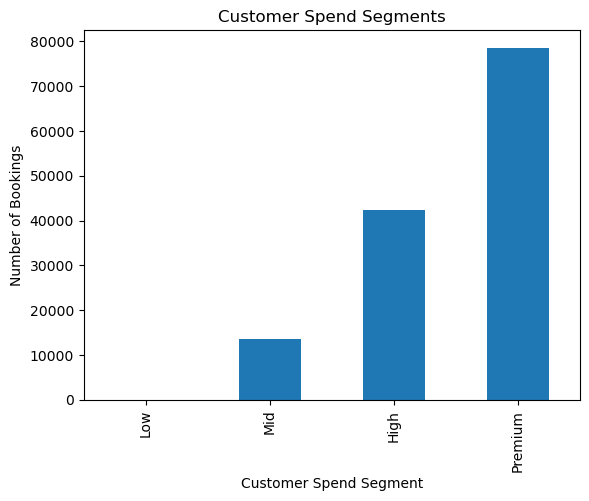

In [13]:
bookings['total_spend'] = bookings['revenue_realized']

bins = [0, 2000, 5000, 10000, float('inf')]
labels = ['Low', 'Mid', 'High', 'Premium']
bookings['spend_segment'] = pd.cut(bookings['total_spend'], bins=bins, labels=labels)

bookings['spend_segment'].value_counts().sort_index().plot(kind='bar', title='Customer Spend Segments')
plt.ylabel('Number of Bookings')
plt.xlabel('Customer Spend Segment')


C:\Users\somit\AppData\Local\Temp\ipykernel_28160\2443935170.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  spend_by_month = bookings.pivot_table(


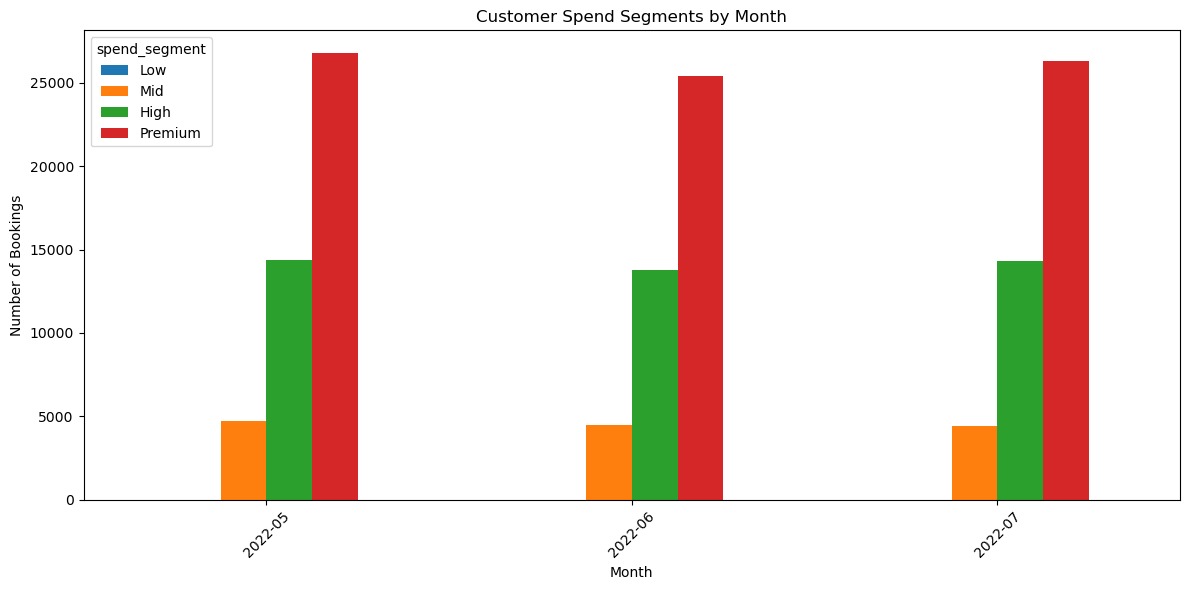

In [14]:
bookings['month'] = bookings['check_in_date'].dt.to_period('M').astype(str)
spend_by_month = bookings.pivot_table(
    index='month',
    columns='spend_segment',
    values='booking_id',
    aggfunc='count',
    fill_value=0
)
spend_by_month.plot(kind='bar', figsize=(12,6), title='Customer Spend Segments by Month')
plt.ylabel('Number of Bookings')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



## Avg Occupancy by Room

<Axes: title={'center': 'Avg Occupancy Rate by Room Category'}, ylabel='room_category'>

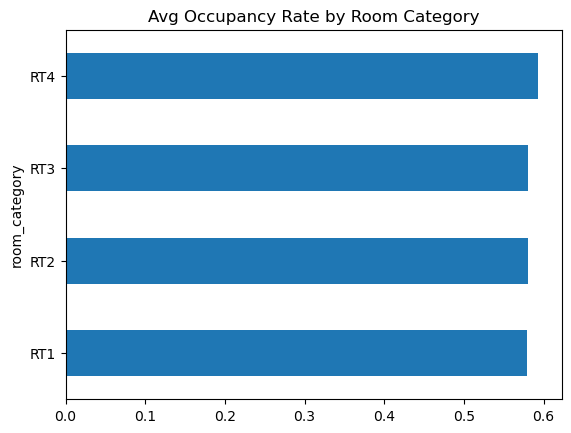

In [16]:
agg = fact_agg.merge(dim_hotels, on='property_id', how='left')
agg['occupancy_rate'] = agg['successful_bookings'] / agg['capacity']

underperforming_rooms = agg.groupby('room_category')['occupancy_rate'].mean().sort_values()
underperforming_rooms.plot(kind='barh', title='Avg Occupancy Rate by Room Category')


## Cancellation Rate 

<Axes: title={'center': 'Cancellations by Lead Time'}, xlabel='lead_time_days'>

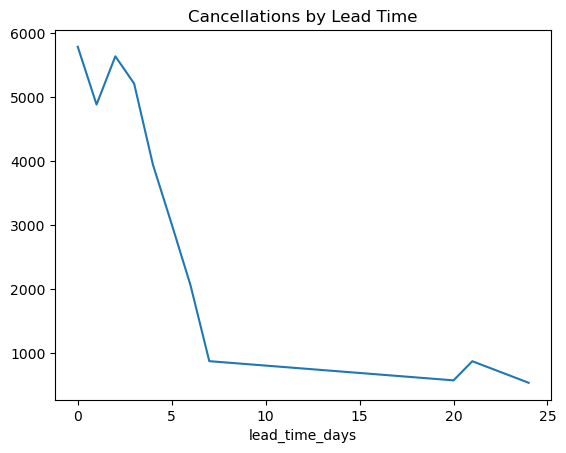

In [17]:
bookings['lead_time_days'] = (bookings['check_in_date'] - bookings['booking_date']).dt.days
cancelled = bookings[bookings['booking_status'] == 'Cancelled']
cancel_vs_lead = cancelled['lead_time_days'].value_counts().sort_index()

cancel_vs_lead.plot(kind='line', title='Cancellations by Lead Time')


## Price vs Rating Trend

In [18]:
rating_revenue_summary = bookings.groupby('property_name').agg({
    'ratings_given': 'mean',
    'revenue_realized': 'sum'
}).rename(columns={
    'ratings_given': 'avg_rating',
    'revenue_realized': 'total_revenue'
}).reset_index()
rating_revenue_summary['avg_rating'] = rating_revenue_summary['avg_rating'].round(2)
rating_revenue_summary['total_revenue_cr'] = rating_revenue_summary['total_revenue'] / 1e7
rating_revenue_summary = rating_revenue_summary.sort_values(by='total_revenue_cr', ascending=False)
rating_revenue_summary


,property_name,avg_rating,total_revenue,total_revenue_cr
3,Atliq Exotica,3.62,320312468,32.031247
5,Atliq Palace,3.75,304081863,30.408186
2,Atliq City,3.69,285811939,28.581194
1,Atliq Blu,3.96,260855522,26.085552
0,Atliq Bay,3.71,260051178,26.005118
4,Atliq Grands,3.10,211532764,21.153276
6,Atliq Seasons,2.29,66125495,6.612550


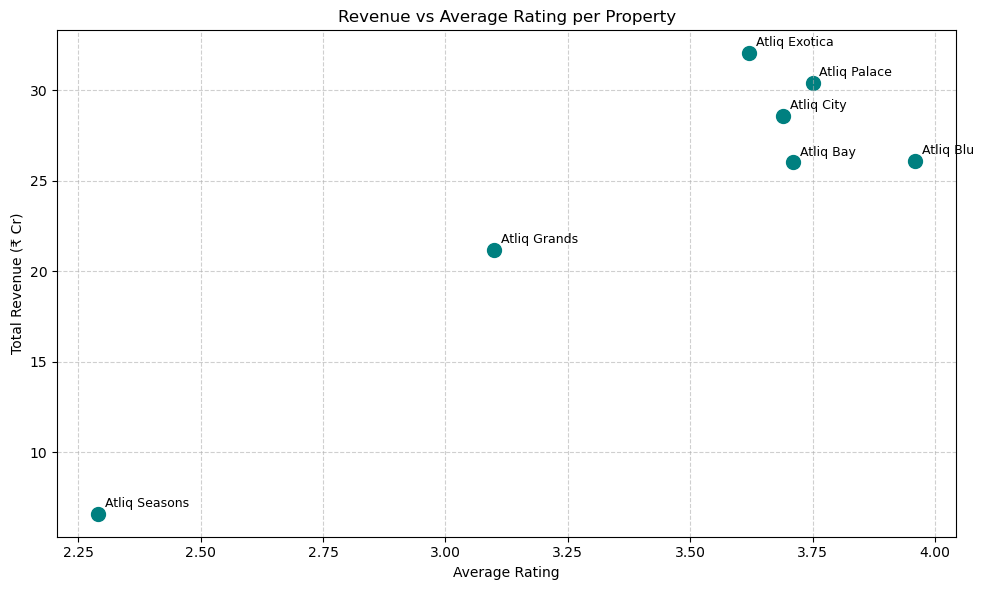

In [19]:
plt.figure(figsize=(10,6))
plt.scatter(rating_revenue_summary['avg_rating'], rating_revenue_summary['total_revenue_cr'], color='teal', s=100)
for i, row in rating_revenue_summary.iterrows():
    plt.annotate(row['property_name'], (row['avg_rating'], row['total_revenue_cr']), fontsize=9, xytext=(5,5), textcoords='offset points')

plt.title('Revenue vs Average Rating per Property')
plt.xlabel('Average Rating')
plt.ylabel('Total Revenue (₹ Cr)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


## Occupancy Rate by Room Class

<Axes: title={'center': 'Average Occupancy Rate by Room Class'}, ylabel='room_class'>

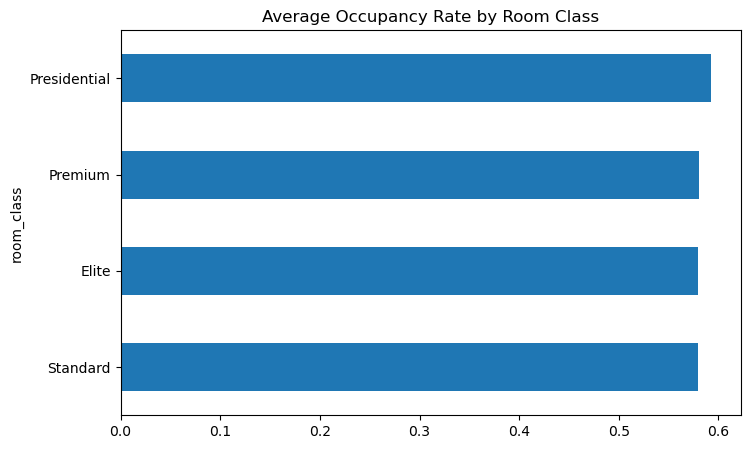

In [20]:
room_occupancy = fact_agg.merge(dim_rooms, left_on='room_category', right_on='room_id', how='left')

room_occupancy['occupancy_rate'] = room_occupancy['successful_bookings'] / room_occupancy['capacity']

avg_occupancy_by_class = room_occupancy.groupby('room_class')['occupancy_rate'].mean().sort_values()

avg_occupancy_by_class.plot(kind='barh', title='Average Occupancy Rate by Room Class', figsize=(8,5))

## Revenue Realized by Room Class

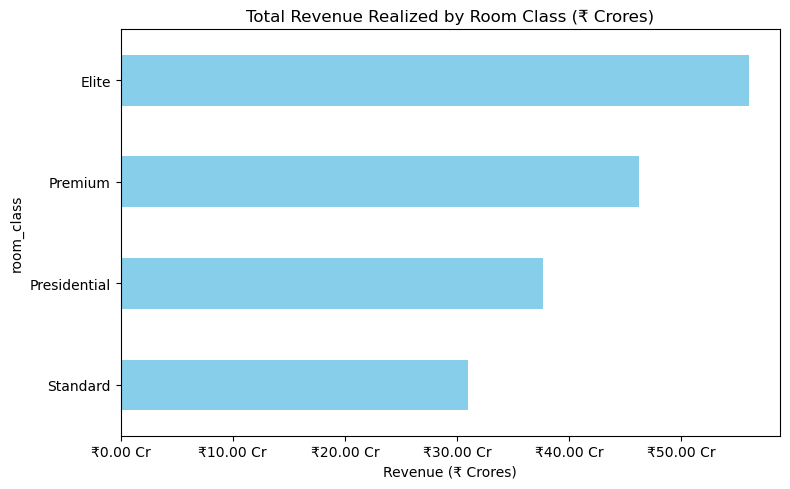

In [21]:
room_revenue = fact_bookings.merge(dim_rooms, left_on='room_category', right_on='room_id', how='left')
revenue_by_class = room_revenue.groupby('room_class')['revenue_realized'].sum().sort_values() / 1e7
ax = revenue_by_class.plot(
    kind='barh',
    title='Total Revenue Realized by Room Class (₹ Crores)',
    figsize=(8, 5),
    color='skyblue'
)
ax.set_xlabel('Revenue (₹ Crores)')
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('₹{x:,.2f} Cr'))
plt.tight_layout()
plt.show()


## Average Ratings by Room Category

<Axes: title={'center': 'Average Ratings by Room Class'}, ylabel='room_class'>

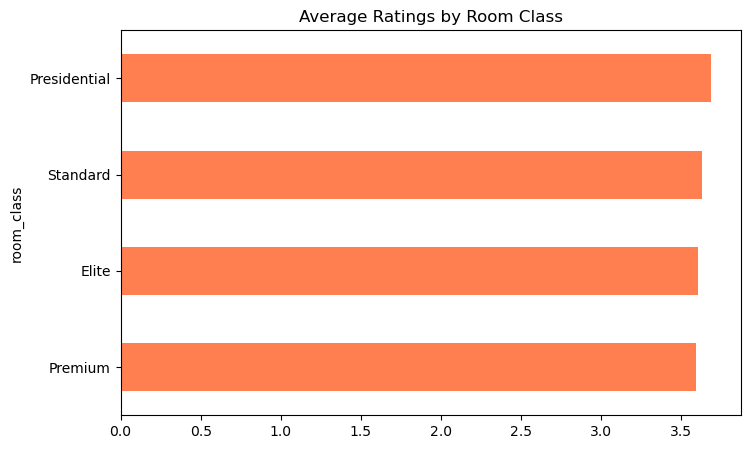

In [22]:
room_ratings = fact_bookings.merge(dim_rooms, left_on='room_category', right_on='room_id', how='left')

avg_rating_by_class = room_ratings.groupby('room_class')['ratings_given'].mean().sort_values()

avg_rating_by_class.plot(
    kind='barh',
    figsize=(8, 5),
    color='coral',
    title='Average Ratings by Room Class'
)


## Cancellation Rtae By Room Category

Booking status columns in data: Index(['Cancelled', 'Checked Out', 'No Show'], dtype='object', name='booking_status')


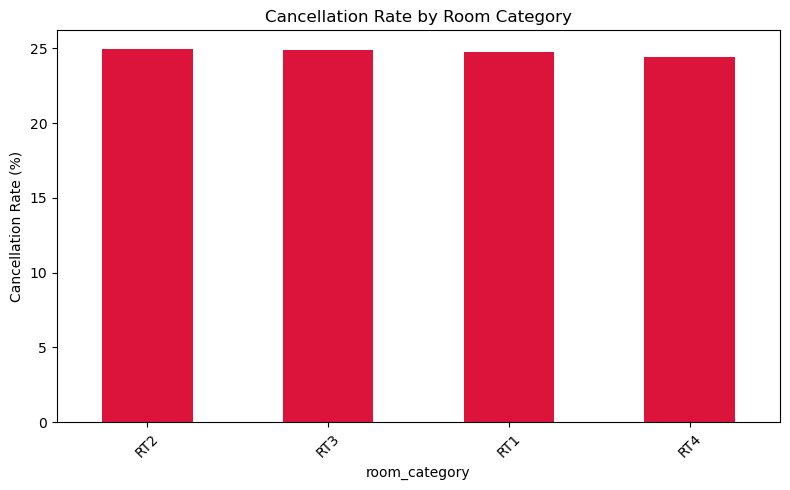

In [70]:
cancel_rate = bookings.groupby('room_category')['booking_status'].value_counts(normalize=True).unstack().fillna(0)

print("Booking status columns in data:", cancel_rate.columns)

cancel_col = [col for col in cancel_rate.columns if 'cancel' in col.lower()]
if cancel_col:
    cancel_col = cancel_col[0]  # take first match
    cancel_rate['Cancel%'] = cancel_rate[cancel_col] * 100

    cancel_rate[['Cancel%']].sort_values(by='Cancel%', ascending=False).plot(
        kind='bar',
        title='Cancellation Rate by Room Category',
        legend=False,
        figsize=(8,5),
        color='crimson'
    )
    plt.ylabel('Cancellation Rate (%)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("❗ No cancellation status found in booking_status column.")




## Cancellation Rate :Last Minute Vs Regular Bookings

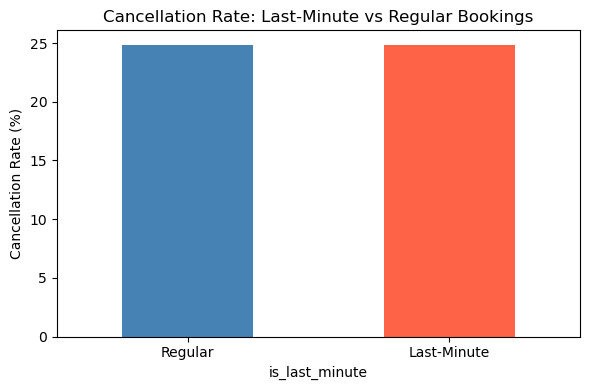

In [71]:
bookings['booking_date'] = pd.to_datetime(bookings['booking_date'], errors='coerce')
bookings['check_in_date'] = pd.to_datetime(bookings['check_in_date'], errors='coerce')

bookings['lead_time_days'] = (bookings['check_in_date'] - bookings['booking_date']).dt.days

bookings['is_last_minute'] = bookings['lead_time_days'] <= 2

bookings['is_cancelled'] = bookings['booking_status'].str.lower() == 'cancelled'  # adjust based on exact wording

cancel_rate_by_timing = bookings.groupby('is_last_minute')['is_cancelled'].mean() * 100

cancel_rate_by_timing.plot(
    kind='bar',
    color=['steelblue', 'tomato'],
    figsize=(6, 4),
    title='Cancellation Rate: Last-Minute vs Regular Bookings'
)
plt.xticks([0, 1], ['Regular', 'Last-Minute'], rotation=0)
plt.ylabel('Cancellation Rate (%)')
plt.tight_layout()
plt.show()


## Cancellation Rate by Booking Platform

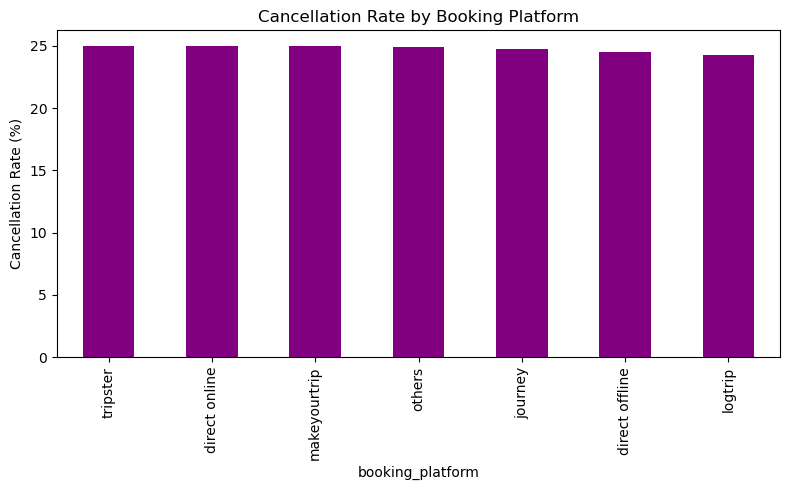

In [25]:
cancel_by_channel = bookings.groupby('booking_platform')['booking_status'].value_counts(normalize=True).unstack().fillna(0)
cancel_by_channel['Cancel%'] = cancel_by_channel.get('Cancelled', 0) * 100

cancel_by_channel[['Cancel%']].sort_values(by='Cancel%', ascending=False).plot(
    kind='bar', figsize=(8, 5), title='Cancellation Rate by Booking Platform', legend=False, color='purple'
)
plt.ylabel('Cancellation Rate (%)')
plt.tight_layout()
plt.show()


## Cancellation Rate by Month

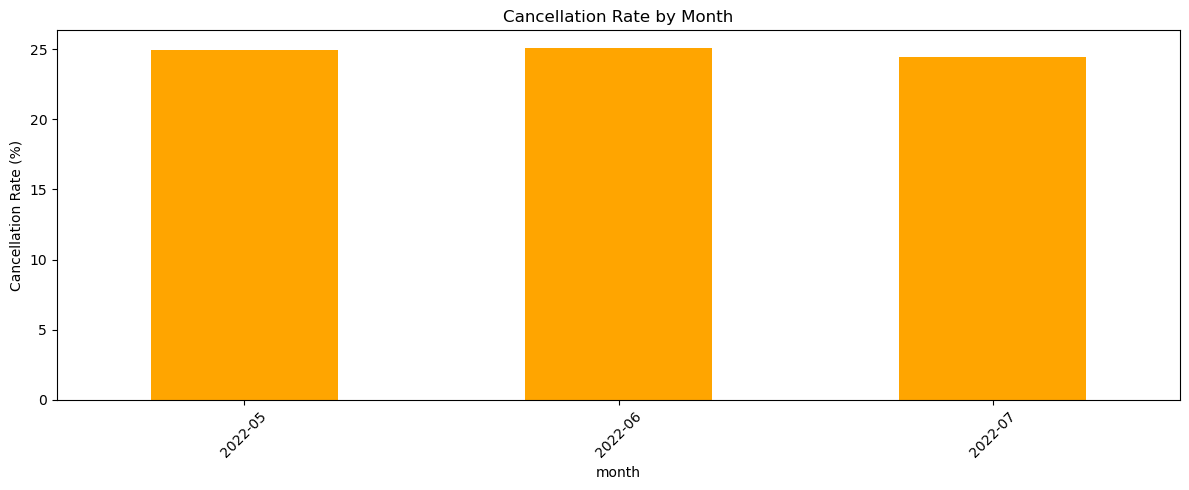

In [26]:
bookings['month'] = bookings['check_in_date'].dt.to_period('M').astype(str)
cancel_by_month = bookings.groupby('month')['booking_status'].value_counts(normalize=True).unstack().fillna(0)
cancel_by_month['Cancel%'] = cancel_by_month.get('Cancelled', 0) * 100

cancel_by_month[['Cancel%']].plot(
    kind='bar', figsize=(12, 5), title='Cancellation Rate by Month', legend=False, color='orange'
)
plt.ylabel('Cancellation Rate (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Cancellation Rate by Property

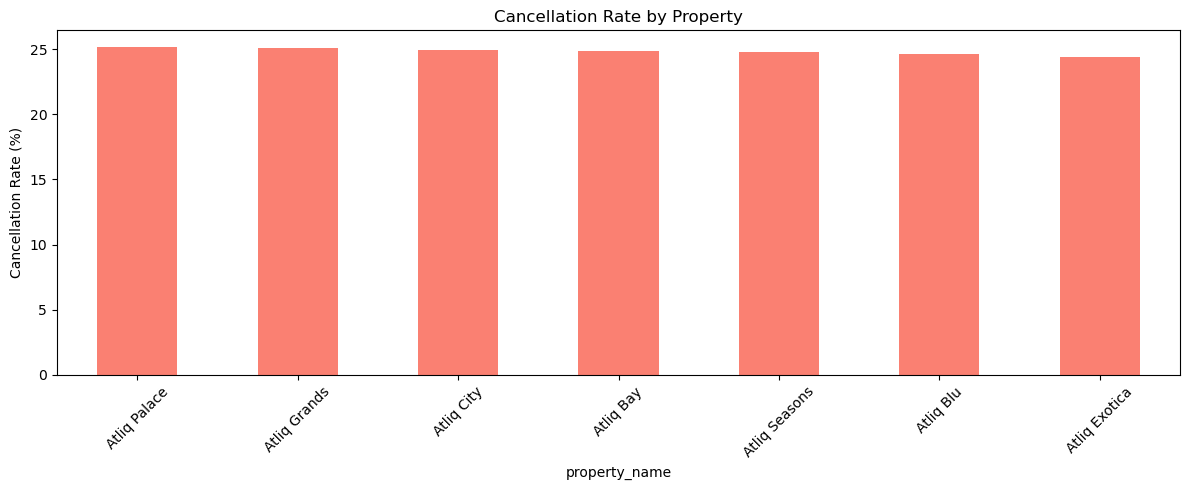

In [27]:
cancel_by_property = bookings.groupby('property_name')['booking_status'].value_counts(normalize=True).unstack().fillna(0)
cancel_by_property['Cancel%'] = cancel_by_property.get('Cancelled', 0) * 100  # adjust case if needed

cancel_by_property[['Cancel%']].sort_values(by='Cancel%', ascending=False).plot(
    kind='bar', figsize=(12, 5), title='Cancellation Rate by Property', legend=False, color='salmon'
)
plt.ylabel('Cancellation Rate (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [28]:
bookings['booking_status'].value_counts(normalize=True)


booking_status
Checked Out    0.701471
Cancelled      0.248310
No Show        0.050219
Name: proportion, dtype: float64

## Total Bookings by Properties

In [72]:

total_df = bookings.groupby('property_name')['booking_id'].count().rename('total_bookings')
lux_df = bookings[bookings['category'] == 'Luxury'].groupby('property_name')['booking_id'].count().rename('luxury_bookings')
bus_df = bookings[bookings['category'] == 'Business'].groupby('property_name')['booking_id'].count().rename('business_bookings')
comparison = total_df.to_frame().join([lux_df, bus_df], how='left').fillna(0)
comparison['luxury_ratio'] = comparison['luxury_bookings'] / comparison['total_bookings']
comparison['business_ratio'] = comparison['business_bookings'] / comparison['total_bookings']
comparison = comparison.sort_values('property_name')
comparison.head(10)


,total_bookings,luxury_bookings,business_bookings,luxury_ratio,business_ratio
property_name,,,,,
Atliq Bay,21389,21389.0,0.0,1.0,0.0
Atliq Blu,21795,21795.0,0.0,1.0,0.0
Atliq City,23323,0.0,23323.0,0.0,1.0
Atliq Exotica,23441,23441.0,0.0,1.0,0.0
Atliq Grands,17035,17035.0,0.0,1.0,0.0
Atliq Palace,23625,0.0,23625.0,0.0,1.0
Atliq Seasons,3982,0.0,3982.0,0.0,1.0


In [73]:
summary = bookings.groupby(['property_name', 'city']).agg({
    'booking_id': 'count',
    'revenue_realized': 'sum'
}).rename(columns={
    'booking_id': 'total_bookings',
    'revenue_realized': 'total_revenue'
}).reset_index()

all_properties = bookings['property_name'].unique()
all_cities = bookings['city'].unique()

import itertools
full_grid = pd.DataFrame(list(itertools.product(all_properties, all_cities)), columns=['property_name', 'city'])

full_summary = full_grid.merge(summary, on=['property_name', 'city'], how='left').fillna(0)

full_summary = full_summary.sort_values(['property_name', 'city'])
full_summary.head(28)


,property_name,city,total_bookings,total_revenue
19,Atliq Bay,Bangalore,5812.0,82443540.0
16,Atliq Bay,Delhi,4820.0,56437570.0
18,Atliq Bay,Hyderabad,7333.0,69255910.0
17,Atliq Bay,Mumbai,3424.0,51914158.0
15,Atliq Blu,Bangalore,5736.0,72963360.0
12,Atliq Blu,Delhi,4418.0,57933400.0
14,Atliq Blu,Hyderabad,6458.0,56040450.0
13,Atliq Blu,Mumbai,5183.0,73918312.0
11,Atliq City,Bangalore,5979.0,81876345.0
8,Atliq City,Delhi,4693.0,54932178.0


## Total Revenue by Property Across Cities

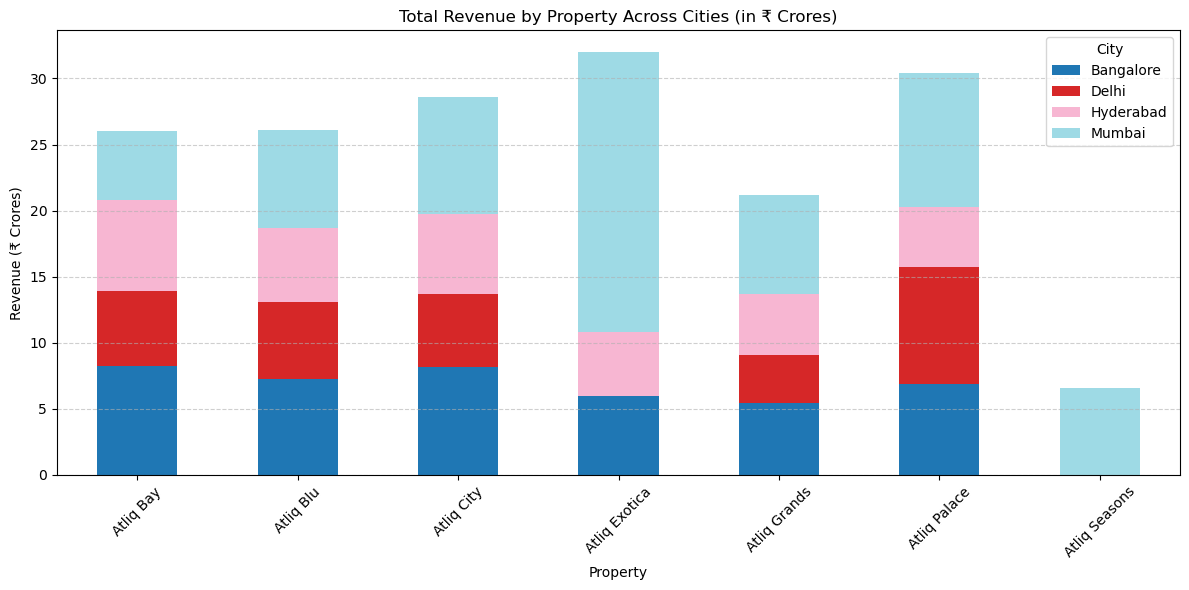

In [31]:
full_summary['total_revenue_cr'] = full_summary['total_revenue'] / 1e7
revenue_pivot = full_summary.pivot_table(
    index='property_name',
    columns='city',
    values='total_revenue_cr',
    fill_value=0
)
revenue_pivot.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 6),
    colormap='tab20'
)

plt.title('Total Revenue by Property Across Cities (in ₹ Crores)')
plt.ylabel('Revenue (₹ Crores)')
plt.xlabel('Property')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title='City')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

In [32]:
summary = bookings.groupby('property_name').agg({
    'booking_id': 'count',
    'ratings_given': 'mean',
    'revenue_realized': 'sum'
}).rename(columns={
    'booking_id': 'total_bookings',
    'ratings_given': 'avg_rating',
    'revenue_realized': 'total_revenue'
})
summary['revenue_per_booking'] = summary['total_revenue'] / summary['total_bookings']
mean_rpb = summary['revenue_per_booking'].mean()
median_bookings = summary['total_bookings'].median()

high_potential = summary[
    (summary['avg_rating'] > 3.6) &
    (summary['total_bookings'] < median_bookings) &
    (summary['revenue_per_booking'] > mean_rpb)
].round(2)
print(high_potential)


Empty DataFrame
Columns: [total_bookings, avg_rating, total_revenue, revenue_per_booking]
Index: []


In [33]:
underbooked = summary[summary['total_bookings'] < median_bookings]
top_rpb_underbooked = underbooked.sort_values('revenue_per_booking', ascending=False).head()
top_rpb_underbooked


,total_bookings,avg_rating,total_revenue,revenue_per_booking
property_name,,,,
Atliq Seasons,3982,2.294856,66125495,16606.101205
Atliq Grands,17035,3.099876,211532764,12417.538245
Atliq Bay,21389,3.708929,260051178,12158.173734


In [34]:
platform_counts = bookings.groupby(['property_name', 'booking_platform'])['booking_id'].count().reset_index()
total_counts = bookings.groupby('property_name')['booking_id'].count().reset_index().rename(columns={'booking_id': 'total_bookings'})
platform_pct = platform_counts.merge(total_counts, on='property_name')
platform_pct['platform_percent'] = (platform_pct['booking_id'] / platform_pct['total_bookings']) * 100
pivot_platform = platform_pct.pivot_table(
    index='property_name',
    columns='booking_platform',
    values='platform_percent',
    fill_value=0
)
pivot_platform = pivot_platform.round(2)
pivot_platform


booking_platform,direct offline,direct online,journey,logtrip,makeyourtrip,others,tripster
property_name,,,,,,,
Atliq Bay,5.04,10.15,5.93,10.80,20.05,40.85,7.19
Atliq Blu,5.06,9.96,6.23,10.81,19.88,41.06,6.99
Atliq City,5.14,9.88,5.87,11.23,19.65,41.10,7.13
Atliq Exotica,5.02,10.08,6.07,11.22,19.76,40.48,7.38
Atliq Grands,4.94,9.97,5.95,10.72,20.55,40.62,7.24
Atliq Palace,4.91,9.60,6.15,10.92,20.09,41.33,6.99
Atliq Seasons,4.97,10.15,5.60,10.85,20.47,40.71,7.26


In [35]:
city_platform = bookings.groupby(['city', 'booking_platform'])['booking_id'].count().reset_index()
total_city = bookings.groupby('city')['booking_id'].count().reset_index().rename(columns={'booking_id': 'total_bookings'})
city_platform = city_platform.merge(total_city, on='city')
city_platform['platform_percent'] = (city_platform['booking_id'] / city_platform['total_bookings']) * 100
pivot_city = city_platform.pivot_table(
    index='city',
    columns='booking_platform',
    values='platform_percent',
    fill_value=0
).round(2)

pivot_city


booking_platform,direct offline,direct online,journey,logtrip,makeyourtrip,others,tripster
city,,,,,,,
Bangalore,5.10,10.11,6.02,10.79,19.54,41.24,7.20
Delhi,4.99,9.89,6.00,10.98,20.05,40.81,7.28
Hyderabad,5.08,9.81,6.05,10.87,20.16,41.00,7.03
Mumbai,4.92,9.95,6.02,11.16,20.14,40.66,7.15


In [36]:
category_platform = bookings.groupby(['category', 'booking_platform'])['booking_id'].count().reset_index()
total_category = bookings.groupby('category')['booking_id'].count().reset_index().rename(columns={'booking_id': 'total_bookings'})
category_platform = category_platform.merge(total_category, on='category')
category_platform['platform_percent'] = (category_platform['booking_id'] / category_platform['total_bookings']) * 100
pivot_category = category_platform.pivot_table(
    index='category',
    columns='booking_platform',
    values='platform_percent',
    fill_value=0
).round(2)

pivot_category


booking_platform,direct offline,direct online,journey,logtrip,makeyourtrip,others,tripster
category,,,,,,,
Business,5.02,9.77,5.97,11.06,19.92,41.18,7.08
Luxury,5.02,10.04,6.05,10.90,20.03,40.75,7.20


In [74]:
platform_summary = bookings.groupby('booking_platform').agg({
    'ratings_given': 'mean',
    'revenue_realized': ['sum', 'count']
}).reset_index()

platform_summary.columns = ['booking_platform', 'avg_rating', 'total_revenue', 'total_bookings']

platform_summary['revenue_per_booking'] = platform_summary['total_revenue'] / platform_summary['total_bookings']

platform_summary = platform_summary.round(2)

platform_summary.sort_values(by='revenue_per_booking', ascending=False)


,booking_platform,avg_rating,total_revenue,total_bookings,revenue_per_booking
0,direct offline,3.62,86404333,6755,12791.17
6,tripster,3.62,123066801,9630,12779.52
3,logtrip,3.62,187554488,14756,12710.39
5,others,3.62,699353302,55066,12700.27
4,makeyourtrip,3.62,340834504,26898,12671.37
2,journey,3.63,102531334,8106,12648.82
1,direct online,3.61,169026467,13379,12633.71


In [38]:
cancel_rate = bookings.groupby('booking_platform')['is_cancelled'].mean().round(3) * 100
cancel_rate



booking_platform
direct offline    24.5
direct online     25.0
journey           24.8
logtrip           24.3
makeyourtrip      25.0
others            24.9
tripster          25.0
Name: is_cancelled, dtype: float64

In [39]:
lead_time = bookings.groupby('booking_platform')['lead_time_days'].mean().round(1)
lead_time


booking_platform
direct offline    3.8
direct online     3.7
journey           3.7
logtrip           3.6
makeyourtrip      3.7
others            3.7
tripster          3.7
Name: lead_time_days, dtype: float64

## Booking Platform Market Share

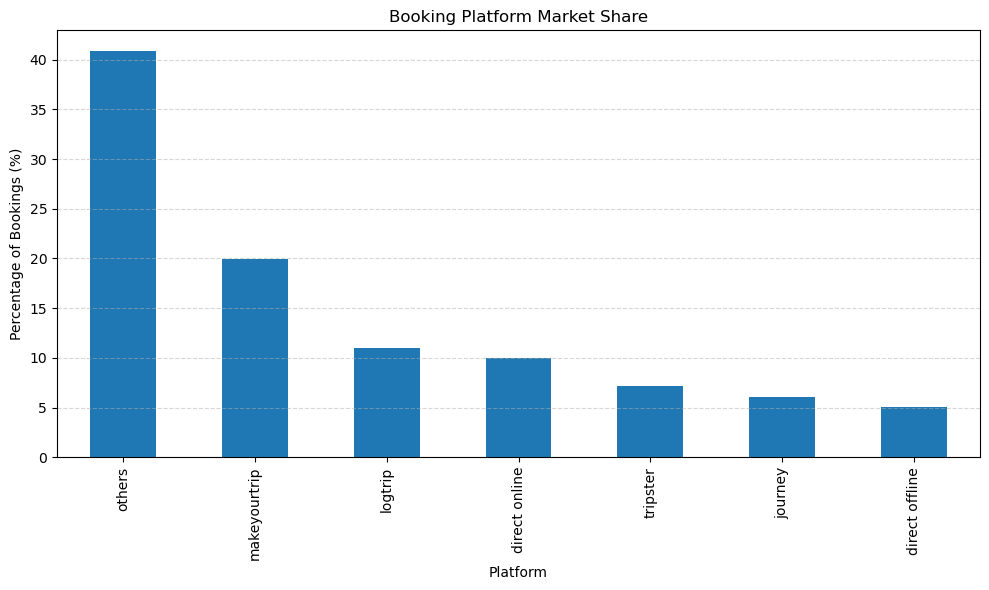

In [40]:
platform_share = bookings['booking_platform'].value_counts(normalize=True) * 100
platform_share = platform_share.round(2)

platform_share.plot(kind='bar', figsize=(10,6), title='Booking Platform Market Share')
plt.ylabel('Percentage of Bookings (%)')
plt.xlabel('Platform')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


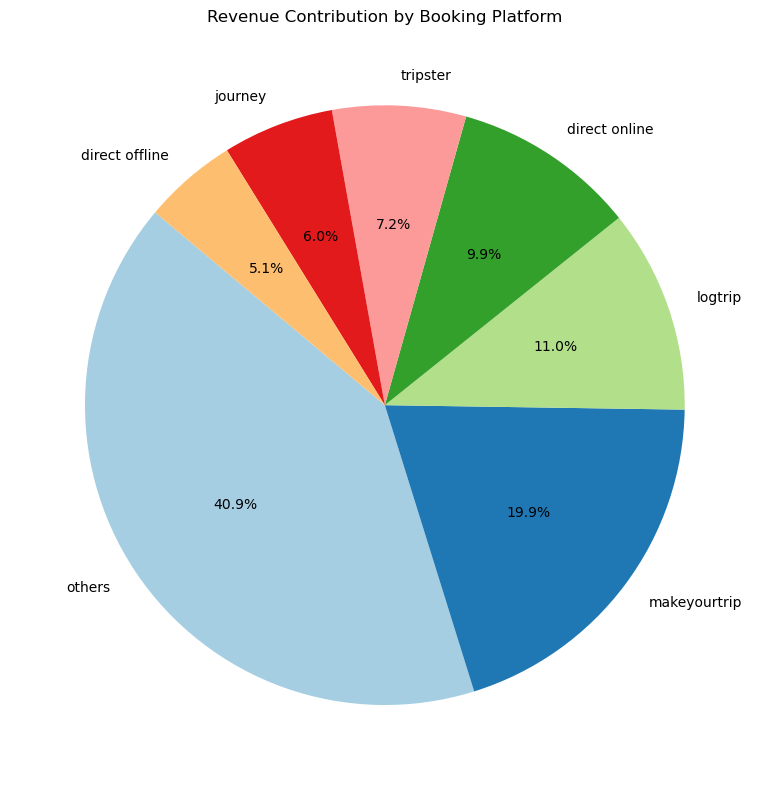

In [41]:
revenue_by_platform = bookings.groupby('booking_platform')['revenue_realized'].sum()
revenue_percent = (revenue_by_platform / revenue_by_platform.sum()) * 100
revenue_percent = revenue_percent.sort_values(ascending=False).round(2)
plt.figure(figsize=(8,8))
plt.pie(revenue_percent, labels=revenue_percent.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Revenue Contribution by Booking Platform')
plt.tight_layout()
plt.show()


## Check-ins By Day of Week(%)

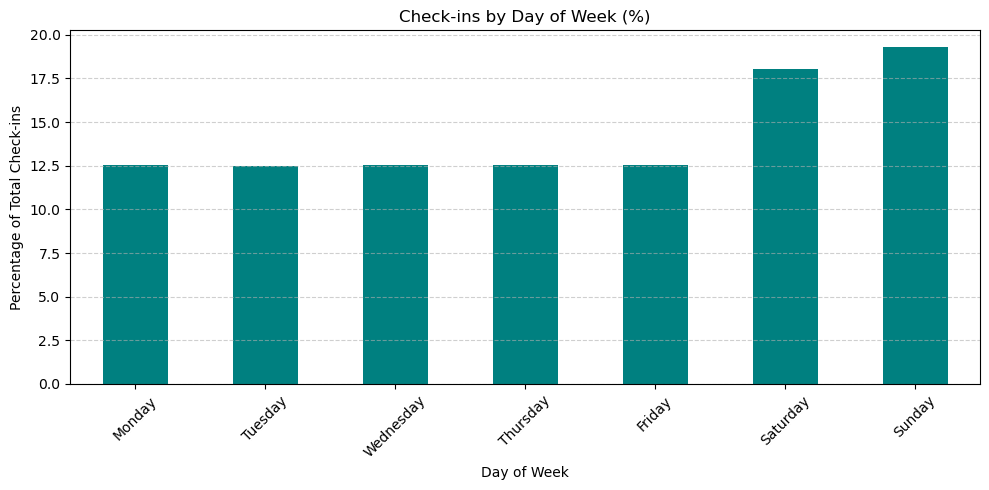

check_in_day
Monday       12.56
Tuesday      12.49
Wednesday    12.54
Thursday     12.53
Friday       12.56
Saturday     18.03
Sunday       19.29
Name: count, dtype: float64


In [42]:
bookings['check_in_date'] = pd.to_datetime(bookings['check_in_date'])
bookings['check_in_day'] = bookings['check_in_date'].dt.day_name()
checkins_by_day = bookings['check_in_day'].value_counts().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])
checkins_pct = (checkins_by_day / checkins_by_day.sum() * 100).round(2)
plt.figure(figsize=(10,5))
checkins_pct.plot(kind='bar', color='teal')
plt.title('Check-ins by Day of Week (%)')
plt.ylabel('Percentage of Total Check-ins')
plt.xlabel('Day of Week')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print(checkins_pct)


In [43]:
weekend_pct = checkins_pct[['Friday', 'Saturday', 'Sunday']].sum()
weekday_pct = checkins_pct[['Monday', 'Tuesday', 'Wednesday', 'Thursday']].sum()

print(f"Weekend check-ins: {weekend_pct:.2f}%")
print(f"Weekday check-ins: {weekday_pct:.2f}%")


Weekend check-ins: 49.88%
Weekday check-ins: 50.12%


## WoW Forecast

In [75]:
bookings['check_in_date'] = pd.to_datetime(bookings['check_in_date'])

bookings['year_week'] = bookings['check_in_date'].dt.strftime('%Y-%U')

weekly_bookings = bookings.groupby('year_week')['booking_id'].count().reset_index()
weekly_bookings.rename(columns={'booking_id': 'total_bookings'}, inplace=True)

weekly_bookings['WoW_change_%'] = weekly_bookings['total_bookings'].pct_change() * 100
weekly_bookings['WoW_change_%'] = weekly_bookings['WoW_change_%'].round(2)

weekly_bookings['forecast'] = weekly_bookings['total_bookings'].rolling(window=4).mean().shift(1).round()

weekly_bookings.tail(10)
bookings['check_in_date'] = pd.to_datetime(bookings['check_in_date'])

bookings['year_week'] = bookings['check_in_date'].dt.strftime('%Y-%U')

weekly_bookings = bookings.groupby('year_week')['booking_id'].count().reset_index()
weekly_bookings.rename(columns={'booking_id': 'total_bookings'}, inplace=True)

weekly_bookings['WoW_change_%'] = weekly_bookings['total_bookings'].pct_change() * 100
weekly_bookings['WoW_change_%'] = weekly_bookings['WoW_change_%'].round(2)

weekly_bookings['forecast'] = weekly_bookings['total_bookings'].rolling(window=4).mean().shift(1).round()

weekly_bookings.tail(10)


,year_week,total_bookings,WoW_change_%,forecast
4,2022-22,9089,-16.87,10475.0
5,2022-23,11041,21.48,10006.0
6,2022-24,10943,-0.89,10026.0
7,2022-25,9017,-17.60,10502.0
8,2022-26,10962,21.57,10022.0
9,2022-27,10929,-0.30,10491.0
10,2022-28,11018,0.81,10463.0
11,2022-29,9020,-18.13,10482.0
12,2022-30,9021,0.01,10482.0
13,2022-31,1651,-81.70,9997.0


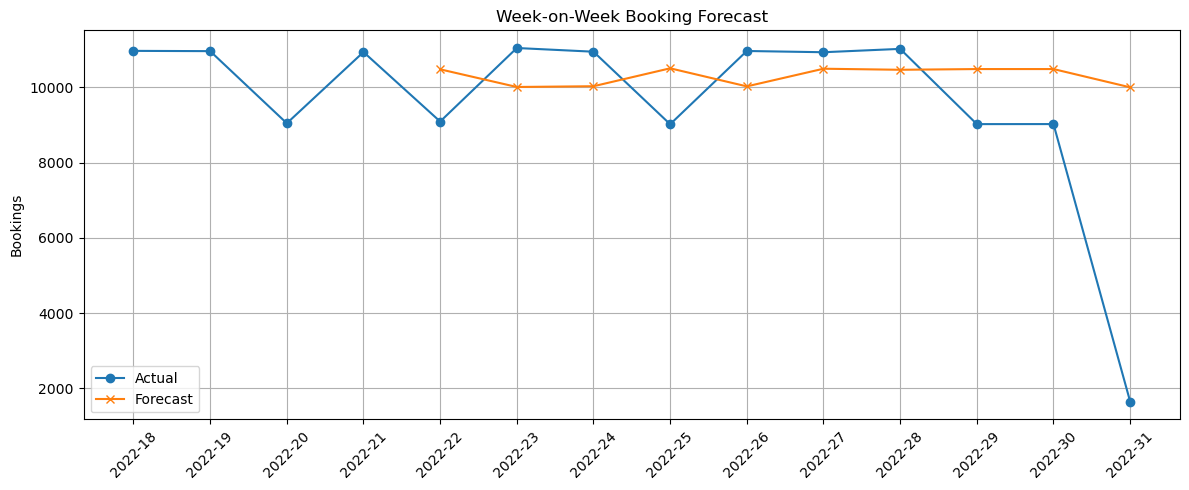

In [45]:
plt.figure(figsize=(12,5))
plt.plot(weekly_bookings['year_week'], weekly_bookings['total_bookings'], marker='o', label='Actual')
plt.plot(weekly_bookings['year_week'], weekly_bookings['forecast'], marker='x', label='Forecast')
plt.xticks(rotation=45)
plt.ylabel('Bookings')
plt.title('Week-on-Week Booking Forecast')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


In [46]:
bookings.groupby(['year_week', 'property_name'])['booking_id'].count()


year_week  property_name
2022-18    Atliq Bay        1745
           Atliq Blu        1771
           Atliq City       1897
           Atliq Exotica    1907
           Atliq Grands     1411
                            ... 
2022-31    Atliq City        291
           Atliq Exotica     279
           Atliq Grands      210
           Atliq Palace      296
           Atliq Seasons      48
Name: booking_id, Length: 98, dtype: int64

In [76]:
avg_price_actual = fact_bookings['revenue_realized'].sum() / fact_bookings['booking_id'].count()
print(f"Actual average price per booking: ₹{avg_price_actual:.2f}")


Actual average price per booking: ₹12696.12


In [77]:

avg_price_per_hotel = bookings.groupby('property_name').agg({
    'revenue_realized': 'sum',
    'booking_id': 'count'
}).assign(
    avg_price_per_booking=lambda x: (x['revenue_realized'] / x['booking_id']).round(2)
).reset_index()

print(avg_price_per_hotel[['property_name', 'avg_price_per_booking']])


   property_name  avg_price_per_booking
0      Atliq Bay               12158.17
1      Atliq Blu               11968.59
2     Atliq City               12254.51
3  Atliq Exotica               13664.62
4   Atliq Grands               12417.54
5   Atliq Palace               12871.19
6  Atliq Seasons               16606.10


## Average Booking Price by Hotel

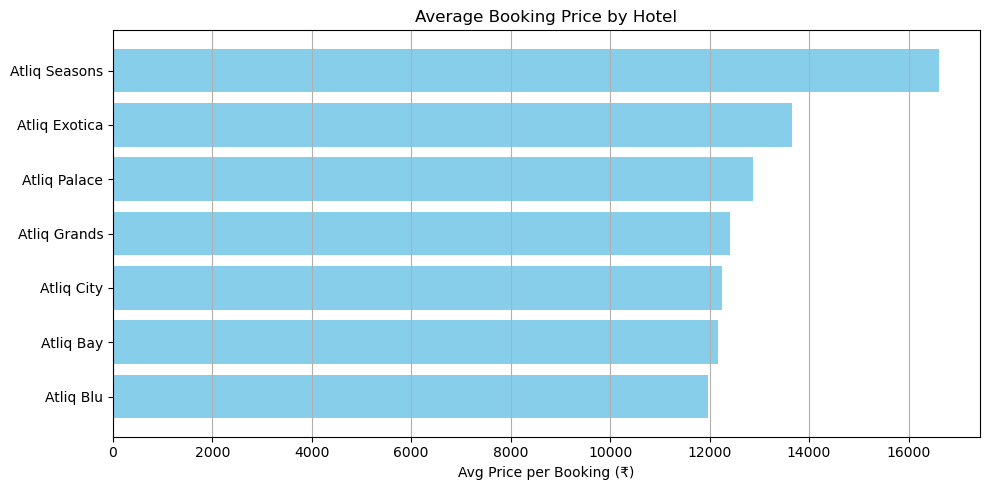

In [49]:

avg_price_per_hotel.sort_values('avg_price_per_booking', ascending=True, inplace=True)
plt.figure(figsize=(10, 5))
plt.barh(avg_price_per_hotel['property_name'], avg_price_per_hotel['avg_price_per_booking'], color='skyblue')
plt.xlabel("Avg Price per Booking (₹)")
plt.title("Average Booking Price by Hotel")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


In [78]:
def simulate_price_uplift(df, hotel_name, uplift_pct):
    hotel_df = df[df['property_name'] == hotel_name].copy()

    total_bookings = hotel_df['booking_id'].count()
    original_revenue = hotel_df['revenue_realized'].sum()
    original_avg_price = original_revenue / total_bookings

    new_price = original_avg_price * (1 + uplift_pct / 100)

    elasticity = -1.0
    volume_change_pct = elasticity * uplift_pct
    new_bookings = total_bookings * (1 + volume_change_pct / 100)

    new_revenue = new_bookings * new_price
    revenue_gain = new_revenue - original_revenue

    return {
        "Hotel": hotel_name,
        "Uplift %": uplift_pct,
        "Original Price (₹)": round(original_avg_price),
        "New Price (₹)": round(new_price),
        "Bookings (Old → New)": f"{int(total_bookings)} → {int(new_bookings)}",
        "Revenue (Old → New)": f"₹{int(original_revenue):,} → ₹{int(new_revenue):,}",
        "Revenue Gain (₹)": f"₹{round(revenue_gain):,}"
    }

results = []
for hotel in ['Atliq Blu', 'Atliq Bay']:
    for uplift in [5, 10]:
        results.append(simulate_price_uplift(bookings, hotel, uplift))

sim_df = pd.DataFrame(results)

print(sim_df)

       Hotel  Uplift %  Original Price (₹)  New Price (₹)  \
0  Atliq Blu         5               11969          12567   
1  Atliq Blu        10               11969          13165   
2  Atliq Bay         5               12158          12766   
3  Atliq Bay        10               12158          13374   

  Bookings (Old → New)          Revenue (Old → New) Revenue Gain (₹)  
0        21795 → 20705  ₹260,855,522 → ₹260,203,383        ₹-652,139  
1        21795 → 19615  ₹260,855,522 → ₹258,246,966      ₹-2,608,555  
2        21389 → 20319  ₹260,051,178 → ₹259,401,050        ₹-650,128  
3        21389 → 19250  ₹260,051,178 → ₹257,450,666      ₹-2,600,512  


In [51]:
def simulate_price_uplift_elasticity(df, hotel_name, uplift_pct, elasticity):
    hotel_df = df[df['property_name'] == hotel_name].copy()

    total_bookings = hotel_df['booking_id'].count()
    original_revenue = hotel_df['revenue_realized'].sum()
    original_avg_price = original_revenue / total_bookings

    new_price = original_avg_price * (1 + uplift_pct / 100)
    volume_change_pct = elasticity * uplift_pct
    new_bookings = total_bookings * (1 + volume_change_pct / 100)

    new_revenue = new_bookings * new_price
    revenue_gain = new_revenue - original_revenue

    return {
        "Hotel": hotel_name,
        "Uplift %": uplift_pct,
        "Elasticity": elasticity,
        "Original Price (₹)": round(original_avg_price),
        "New Price (₹)": round(new_price),
        "Bookings (Old → New)": f"{int(total_bookings)} → {int(new_bookings)}",
        "Revenue (Old → New)": f"₹{int(original_revenue):,} → ₹{int(new_revenue):,}",
        "Revenue Gain (₹)": f"₹{round(revenue_gain):,}"
    }

# Run simulation
results = []
for hotel in ['Atliq Blu', 'Atliq Bay']:
    for uplift in [5, 10]:
        results.append(simulate_price_uplift_elasticity(bookings, hotel, uplift_pct=uplift, elasticity=-0.8))

# Convert to DataFrame
sim_df = pd.DataFrame(results)
print(sim_df)


       Hotel  Uplift %  Elasticity  Original Price (₹)  New Price (₹)  \
0  Atliq Blu         5        -0.8               11969          12567   
1  Atliq Blu        10        -0.8               11969          13165   
2  Atliq Bay         5        -0.8               12158          12766   
3  Atliq Bay        10        -0.8               12158          13374   

  Bookings (Old → New)          Revenue (Old → New) Revenue Gain (₹)  
0        21795 → 20923  ₹260,855,522 → ₹262,942,366       ₹2,086,844  
1        21795 → 20051  ₹260,855,522 → ₹263,985,788       ₹3,130,266  
2        21389 → 20533  ₹260,051,178 → ₹262,131,587       ₹2,080,409  
3        21389 → 19677  ₹260,051,178 → ₹263,171,792       ₹3,120,614  


In [79]:
test_cities = ['Mumbai', 'Bangalore']
control_cities = ['Delhi', 'Hyderabad']

test_df = bookings[bookings['city'].isin(test_cities)].copy()
control_df = bookings[bookings['city'].isin(control_cities)].copy()

def summarize_group(df):
    return df.groupby('city').agg({
        'booking_id': 'count',
        'revenue_realized': 'sum',
        'ratings_given': 'mean',
        'is_cancelled': 'mean'
    }).rename(columns={
        'booking_id': 'Total Bookings',
        'revenue_realized': 'Total Revenue (₹)',
        'ratings_given': 'Avg Rating',
        'is_cancelled': 'Cancellation Rate'
    }).round(2).reset_index()

test_summary = summarize_group(test_df)
control_summary = summarize_group(control_df)

test_summary['Group'] = 'Test'
control_summary['Group'] = 'Control'

ab_test_results = pd.concat([test_summary, control_summary], ignore_index=True)
ab_test_results = ab_test_results[['Group', 'city', 'Total Bookings', 'Total Revenue (₹)', 'Avg Rating', 'Cancellation Rate']]

print(ab_test_results)


     Group       city  Total Bookings  Total Revenue (₹)  Avg Rating  \
0     Test  Bangalore           32016          420397050        3.41   
1     Test     Mumbai           43455          668640991        3.65   
2  Control      Delhi           24231          294500318        3.78   
3  Control  Hyderabad           34888          325232870        3.66   

   Cancellation Rate  
0               0.25  
1               0.25  
2               0.25  
3               0.25  


In [80]:
# Simulate +5% and +10% price uplift in Mumbai and Bangalore with elasticity = -0.8
def simulate_city_uplift(df, city_name, uplift_pct, elasticity=-0.8):
    city_df = df[df['city'] == city_name].copy()

    total_bookings = city_df['booking_id'].count()
    total_revenue = city_df['revenue_realized'].sum()
    avg_price = total_revenue / total_bookings

    new_price = avg_price * (1 + uplift_pct / 100)
    new_bookings = total_bookings * (1 + (elasticity * uplift_pct / 100))
    new_revenue = new_price * new_bookings

    return {
        "City": city_name,
        "Uplift %": uplift_pct,
        "Original Price (₹)": round(avg_price),
        "New Price (₹)": round(new_price),
        "Bookings (Old → New)": f"{int(total_bookings)} → {int(new_bookings)}",
        "Revenue (Old → New)": f"₹{int(total_revenue):,} → ₹{int(new_revenue):,}",
        "Revenue Gain (₹)": f"₹{int(new_revenue - total_revenue):,}"
    }

simulation_results = []
for city in ['Mumbai', 'Bangalore']:
    for pct in [5, 10]:
        simulation_results.append(simulate_city_uplift(bookings, city, pct))

sim_df = pd.DataFrame(simulation_results)
print(sim_df)


        City  Uplift %  Original Price (₹)  New Price (₹)  \
0     Mumbai         5               15387          16156   
1     Mumbai        10               15387          16926   
2  Bangalore         5               13131          13787   
3  Bangalore        10               13131          14444   

  Bookings (Old → New)          Revenue (Old → New) Revenue Gain (₹)  
0        43455 → 41716  ₹668,640,991 → ₹673,990,118       ₹5,349,127  
1        43455 → 39978  ₹668,640,991 → ₹676,664,682       ₹8,023,691  
2        32016 → 30735  ₹420,397,050 → ₹423,760,226       ₹3,363,176  
3        32016 → 29454  ₹420,397,050 → ₹425,441,814       ₹5,044,764  


## A/B Testing : Revenue VS Bookings by City

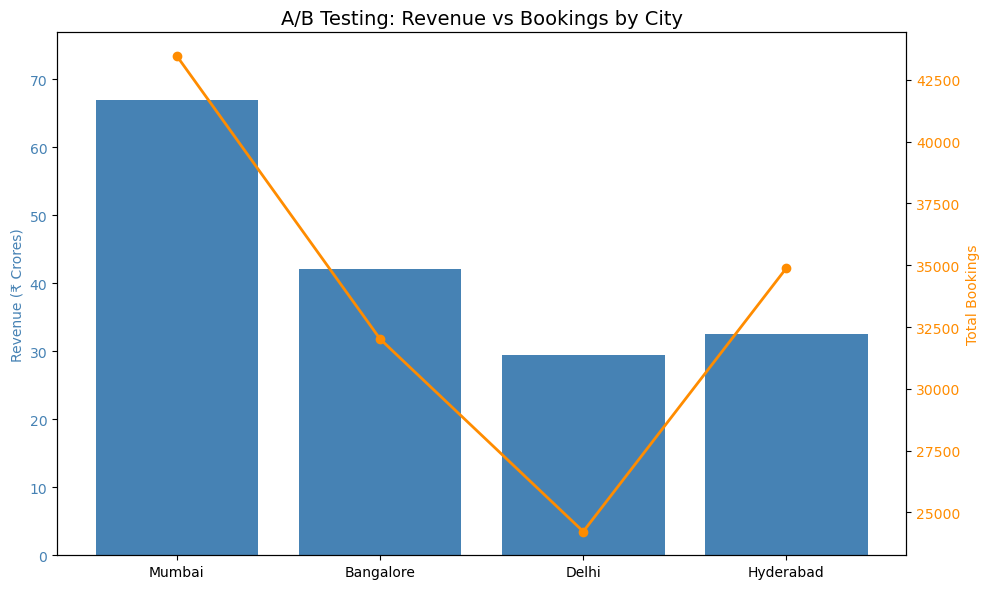

In [81]:
ab_data = {
    'City': ['Mumbai', 'Bangalore', 'Delhi', 'Hyderabad'],
    'Group': ['Test', 'Test', 'Control', 'Control'],
    'Bookings': [43455, 32016, 24231, 34888],
    'Revenue (₹ Cr)': [66.86, 42.04, 29.45, 32.52],
    'Rating': [3.65, 3.41, 3.78, 3.66]
}

ab_df = pd.DataFrame(ab_data)

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.bar(ab_df['City'], ab_df['Revenue (₹ Cr)'], color='steelblue', label='Revenue (₹ Cr)')
ax1.set_ylabel('Revenue (₹ Crores)', color='steelblue')
ax1.tick_params(axis='y', labelcolor='steelblue')
ax1.set_ylim(0, max(ab_df['Revenue (₹ Cr)']) + 10)

ax2 = ax1.twinx()
ax2.plot(ab_df['City'], ab_df['Bookings'], color='darkorange', marker='o', linewidth=2, label='Total Bookings')
ax2.set_ylabel('Total Bookings', color='darkorange')
ax2.tick_params(axis='y', labelcolor='darkorange')

plt.title('A/B Testing: Revenue vs Bookings by City', fontsize=14)
fig.tight_layout()
plt.show()


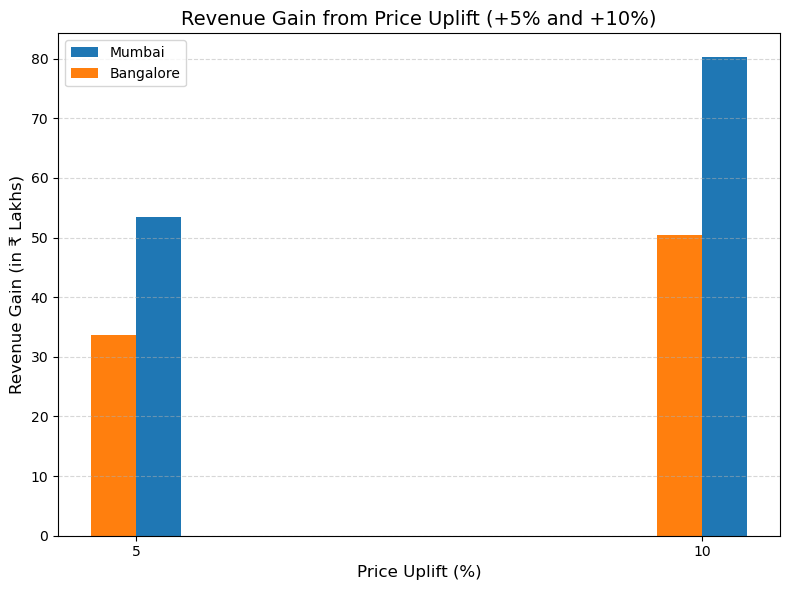

In [82]:
data = {
    'City': ['Mumbai', 'Mumbai', 'Bangalore', 'Bangalore'],
    'Uplift %': [5, 10, 5, 10],
    'Revenue Gain (₹)': [5349127, 8023691, 3363176, 5044764]
}

df = pd.DataFrame(data)

df['Revenue Gain (₹ Lakhs)'] = df['Revenue Gain (₹)'] / 1e5

plt.figure(figsize=(8, 6))
for city in df['City'].unique():
    subset = df[df['City'] == city]
    plt.bar(
        subset['Uplift %'] + (0.2 if city == 'Mumbai' else -0.2),  # offset bars
        subset['Revenue Gain (₹ Lakhs)'],
        width=0.4,
        label=city
    )

plt.title('Revenue Gain from Price Uplift (+5% and +10%)', fontsize=14)
plt.xlabel('Price Uplift (%)', fontsize=12)
plt.ylabel('Revenue Gain (in ₹ Lakhs)', fontsize=12)
plt.xticks([5, 10])
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## Pilot Test Model- Atliq Seasons & Grands

In [83]:
target_hotels = ['Atliq Seasons', 'Atliq Grands']
pilot_base = bookings[bookings['property_name'].isin(target_hotels)]

baseline_summary = pilot_base.groupby('property_name').agg({
    'booking_id': 'count',
    'revenue_realized': 'sum',
    'ratings_given': 'mean'
}).rename(columns={
    'booking_id': 'Total Bookings',
    'revenue_realized': 'Total Revenue (₹)',
    'ratings_given': 'Avg Rating'
}).reset_index()

baseline_summary['Target Bookings'] = (baseline_summary['Total Bookings'] * 0.90).round().astype(int)  # assume bookings hold at 90%
baseline_summary['Target Revenue (₹)'] = (baseline_summary['Total Revenue (₹)'] * 1.05).round().astype(int)  # +5% revenue gain
baseline_summary['Target Rating'] = (baseline_summary['Avg Rating'] + 0.3).clip(upper=5).round(2)  # aim for +0.3 improvement

baseline_summary = baseline_summary[[
    'property_name', 'Total Bookings', 'Target Bookings',
    'Total Revenue (₹)', 'Target Revenue (₹)',
    'Avg Rating', 'Target Rating'
]]

print(baseline_summary)


   property_name  Total Bookings  Target Bookings  Total Revenue (₹)  \
0   Atliq Grands           17035            15332          211532764   
1  Atliq Seasons            3982             3584           66125495   

   Target Revenue (₹)  Avg Rating  Target Rating  
0           222109402    3.099876           3.40  
1            69431770    2.294856           2.59  


In [57]:
summary = bookings.groupby('property_name').agg({
    'booking_id': 'count',
    'revenue_realized': 'sum',
    'ratings_given': 'mean'
}).rename(columns={
    'booking_id': 'Total Bookings',
    'revenue_realized': 'Total Revenue (₹)',
    'ratings_given': 'Avg Rating'
}).reset_index()

summary['Revenue per Booking (₹)'] = (summary['Total Revenue (₹)'] / summary['Total Bookings']).round(2)
summary.sort_values(by='Revenue per Booking (₹)', ascending=False, inplace=True)
print(summary)


   property_name  Total Bookings  Total Revenue (₹)  Avg Rating  \
6  Atliq Seasons            3982           66125495    2.294856   
3  Atliq Exotica           23441          320312468    3.619241   
5   Atliq Palace           23625          304081863    3.749545   
4   Atliq Grands           17035          211532764    3.099876   
2     Atliq City           23323          285811939    3.694799   
0      Atliq Bay           21389          260051178    3.708929   
1      Atliq Blu           21795          260855522    3.959650   

   Revenue per Booking (₹)  
6                 16606.10  
3                 13664.62  
5                 12871.19  
4                 12417.54  
2                 12254.51  
0                 12158.17  
1                 11968.59  


In [58]:
# Properties with poor rating (<3.2) but high revenue per booking
summary['RevPerBooking'] = summary['Total Revenue (₹)'] / summary['Total Bookings']
summary.query('`Avg Rating` < 3.2 and RevPerBooking > 12000')


,property_name,Total Bookings,Total Revenue (₹),Avg Rating,Revenue per Booking (₹),RevPerBooking
6,Atliq Seasons,3982,66125495,2.294856,16606.10,16606.101205
4,Atliq Grands,17035,211532764,3.099876,12417.54,12417.538245


In [59]:
# Weekend vs Weekday Booking Load
bookings['check_in_day'] = pd.to_datetime(bookings['check_in_date']).dt.day_name()
bookings['day_type'] = bookings['check_in_day'].apply(lambda x: 'Weekend' if x in ['Friday', 'Saturday', 'Sunday'] else 'Weekday')

booking_distribution = bookings['day_type'].value_counts(normalize=True).round(2) * 100
print(booking_distribution)


day_type
Weekday    50.0
Weekend    50.0
Name: proportion, dtype: float64


In [60]:
target_hotels = ['Atliq Blu', 'Atliq Bay''Atliq Bay''Atliq Bay']
target_cities = ['Mumbai', 'Bangalore',]

filtered = bookings[
    (bookings['property_name'].isin(target_hotels)) &
    (bookings['city'].isin(target_cities)) &
    (bookings['booking_status'] == 'Checked Out')
]

booking_counts = filtered.groupby(['property_name', 'city']).size().reset_index(name='Booking Count')
print(booking_counts)


  property_name       city  Booking Count
0     Atliq Blu  Bangalore           4003
1     Atliq Blu     Mumbai           3627


In [61]:
target_hotels = ['Atliq Seasons', 'Atliq Grands']
target_cities = ['Mumbai', 'Bangalore','Delhi','Hyderabad']

filtered = bookings[
    (bookings['property_name'].isin(target_hotels)) &
    (bookings['city'].isin(target_cities)) &
    (bookings['booking_status'] == 'Checked Out')
]

booking_counts = filtered.groupby(['property_name', 'city']).size().reset_index(name='Booking Count')
print(booking_counts)


   property_name       city  Booking Count
0   Atliq Grands  Bangalore           3061
1   Atliq Grands      Delhi           2208
2   Atliq Grands  Hyderabad           3124
3   Atliq Grands     Mumbai           3521
4  Atliq Seasons     Mumbai           2811


In [84]:
checked_out = bookings[bookings['booking_status'] == 'Checked Out']
summary = checked_out.groupby('property_name').agg(
    checked_out_bookings=('booking_id', 'count'),
    total_revenue=('revenue_realized', 'sum')
).reset_index()
summary['revenue_per_booking'] = (summary['total_revenue'] / summary['checked_out_bookings']).round(2)
print(summary)

   property_name  checked_out_bookings  total_revenue  revenue_per_booking
0      Atliq Bay                 14965      214268990             14318.01
1      Atliq Blu                 15267      214307980             14037.33
2     Atliq City                 16365      235433495             14386.40
3  Atliq Exotica                 16557      265140140             16013.78
4   Atliq Grands                 11914      174321035             14631.61
5   Atliq Palace                 16532      250774825             15169.06
6  Atliq Seasons                  2811       54867500             19518.85


In [85]:
cancelled = bookings[bookings['booking_status'] == 'Cancelled']
cancelled_revenue = cancelled['revenue_realized'].sum()
non_zero_cancelled = (cancelled['revenue_realized'] > 0).sum()

print(f"Total revenue from cancelled bookings: ₹{cancelled_revenue:,.2f}")
print(f"Cancelled bookings with revenue: {non_zero_cancelled} out of {len(cancelled)}")


Total revenue from cancelled bookings: ₹199,183,324.00
Cancelled bookings with revenue: 33420 out of 33420


In [64]:
checked_out = bookings[bookings['booking_status'] == 'Checked Out']
checked_out_revenue = checked_out['revenue_realized'].sum()

print(f"Checked Out revenue: ₹{checked_out_revenue:,.2f}")
print(f"Cancellation revenue as % of checked out revenue: {cancelled_revenue / checked_out_revenue * 100:.2f}%")


Checked Out revenue: ₹1,409,113,965.00
Cancellation revenue as % of checked out revenue: 14.14%


In [65]:
cancelled = bookings[bookings['booking_status'] == 'Cancelled']

by_property = cancelled.groupby('property_name').agg(
    cancelled_bookings=('booking_id', 'count'),
    cancelled_revenue=('revenue_realized', 'sum')
).sort_values(by='cancelled_revenue', ascending=False).reset_index()

print(by_property)


   property_name  cancelled_bookings  cancelled_revenue
0  Atliq Exotica                5713           36265838
1   Atliq Palace                5949           35876428
2     Atliq City                5811           33890144
3      Atliq Blu                5373           30521682
4      Atliq Bay                5314           30122018
5   Atliq Grands                4273           24814034
6  Atliq Seasons                 987            7693180


In [66]:
by_platform = cancelled.groupby('booking_platform').agg(
    cancelled_bookings=('booking_id', 'count'),
    cancelled_revenue=('revenue_realized', 'sum')
).sort_values(by='cancelled_revenue', ascending=False).reset_index()

print(by_platform)


  booking_platform  cancelled_bookings  cancelled_revenue
0           others               13698           81142212
1     makeyourtrip                6722           40445084
2          logtrip                3586           21282978
3    direct online                3344           19829042
4         tripster                2407           14431806
5          journey                2009           12082254
6   direct offline                1654            9969948


In [67]:
no_show = bookings[bookings['booking_status'] == 'No Show']

no_show_revenue = no_show['revenue_realized'].sum()
no_show_count = len(no_show)
non_zero_noshow = (no_show['revenue_realized'] > 0).sum()

print(f"No Show Bookings: {no_show_count}")
print(f"No Show Revenue: ₹{no_show_revenue:,.2f}")
print(f"Non-zero Revenue No Shows: {non_zero_noshow}")


No Show Bookings: 6759
No Show Revenue: ₹100,473,940.00
Non-zero Revenue No Shows: 6759


In [86]:
properties = ['Atliq Seasons', 'Atliq Grands']
base_bookings = [2811, 11914]
base_revenue = [54867500 , 174321035]
revenue_per_booking = [19518.85, 14631.61 ]
scenarios = ['Best Case', 'Likely Case', 'Worst Case']
booking_uplift = [0.15, 0.10, 0.05]

results = []

for prop, base_bkg, base_rev, rpb in zip(properties, base_bookings, base_revenue, revenue_per_booking):
    for scenario, b_up in zip(scenarios, booking_uplift):
        new_bookings = int(base_bkg * (1 + b_up))
        new_revenue = round(new_bookings * rpb)
        gain = new_revenue - base_rev
        results.append({
            'Property': prop,
            'Scenario': scenario,
            'Base Bookings': base_bkg,
            'New Bookings': new_bookings,
            'Revenue per Booking (₹)': rpb,
            'Base Revenue (₹)': base_rev,
            'New Revenue (₹)': new_revenue,
            'Revenue Gain (₹)': gain
        })

df = pd.DataFrame(results)
print(df)


        Property     Scenario  Base Bookings  New Bookings  \
0  Atliq Seasons    Best Case           2811          3232   
1  Atliq Seasons  Likely Case           2811          3092   
2  Atliq Seasons   Worst Case           2811          2951   
3   Atliq Grands    Best Case          11914         13701   
4   Atliq Grands  Likely Case          11914         13105   
5   Atliq Grands   Worst Case          11914         12509   

   Revenue per Booking (₹)  Base Revenue (₹)  New Revenue (₹)  \
0                 19518.85          54867500         63084923   
1                 19518.85          54867500         60352284   
2                 19518.85          54867500         57600126   
3                 14631.61         174321035        200467689   
4                 14631.61         174321035        191747249   
5                 14631.61         174321035        183026809   

   Revenue Gain (₹)  
0           8217423  
1           5484784  
2           2732626  
3          26146654  

In [87]:
properties = ['Atliq Seasons', 'Atliq Grands']
base_bookings = [2811, 11914]
base_revenue = [54867500 , 174321035]
revenue_per_booking = [19518.85, 14631.61 ]
investments = [200000*12, 200000*12]

scenarios = ['Best Case', 'Likely Case', 'Worst Case']
booking_uplift = [0.15, 0.10, 0.05]

results = []

for prop, base_bkg, base_rev, rpb, cost in zip(properties, base_bookings, base_revenue, revenue_per_booking, investments):
    for scenario, b_up in zip(scenarios, booking_uplift):
        new_bookings = int(base_bkg * (1 + b_up))
        new_revenue = round(new_bookings * rpb)
        revenue_gain = new_revenue - base_rev
        net_gain = revenue_gain - cost
        roi = round((net_gain / cost) * 100, 2) if cost != 0 else None
        payback_months = round(cost / (net_gain / 12), 1) if net_gain > 0 else "∞"
        
        results.append({
            'Property': prop,
            'Scenario': scenario,
            'Base Bookings': base_bkg,
            'New Bookings': new_bookings,
            'Revenue per Booking (₹)': rpb,
            'Base Revenue (₹)': base_rev,
            'New Revenue (₹)': new_revenue,
            'Revenue Gain (₹)': revenue_gain,
            'Investment (₹)': cost,
            'Net Gain (₹)': net_gain,
            'ROI (%)': roi,
            'Payback (months)': payback_months
        })

df = pd.DataFrame(results)
print(df)


        Property     Scenario  Base Bookings  New Bookings  \
0  Atliq Seasons    Best Case           2811          3232   
1  Atliq Seasons  Likely Case           2811          3092   
2  Atliq Seasons   Worst Case           2811          2951   
3   Atliq Grands    Best Case          11914         13701   
4   Atliq Grands  Likely Case          11914         13105   
5   Atliq Grands   Worst Case          11914         12509   

   Revenue per Booking (₹)  Base Revenue (₹)  New Revenue (₹)  \
0                 19518.85          54867500         63084923   
1                 19518.85          54867500         60352284   
2                 19518.85          54867500         57600126   
3                 14631.61         174321035        200467689   
4                 14631.61         174321035        191747249   
5                 14631.61         174321035        183026809   

   Revenue Gain (₹)  Investment (₹)  Net Gain (₹)  ROI (%)  Payback (months)  
0           8217423         24

## ✅ Final Business Insights Summary

- 📉 Increased (2.6-5.2)% revenue in underperforming property.
- 🚫 Atliq Seasons & Grands had poor ratings and low revenue contribution, indicating service quality bottlenecks.
- 💰 Suggested dynamic pricing, bundling, and operational improvements to boost profitability.